In [9]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import encoder_files_to_tensors, get_best_model_timestamp
from utils import unnormalize_params
from utils import sample_files, fast_tensor_load
from models import EncoderMulti
from sklearn.metrics import mean_squared_error

# data_dir = './tomo_data/datasets_encoder_TF_03-03-23'
data_dir = './tomo_data/datasets_encoder_TF_24-03-23'


dataset_percent = 0.5
normalization = 'minmax'
img_normalize = 'off'
num_Turns_Case = 1

var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# timestamp = get_best_model_timestamp('./trials', model='enc')
# timestamp = '2022_12_18_11-48-57'
# timestamp = '2023_04_21_10-02-52'
timestamp = 'best_encoder_TF'

# timestamp = 'best_encoder_TF_new'


In [10]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

assert normalization == 'minmax'
assert img_normalize == 'off'
TESTING_PATH = os.path.join(ML_dir, 'testing-??.npz')

# First the training data
start_t = time.time()
x_test, y_test = fast_tensor_load(TESTING_PATH, dataset_percent)
print('Number of Testing files: ', len(y_test))
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(y_test):.3f}')


Loading ./tomo_data/datasets_encoder_TF_24-03-23/ML_data/testing-00.npz
Number of Testing files:  698
Elapsed time: 0.281, Per file: 0.000


In [11]:
# Model to load

print(timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

encoder = EncoderMulti(weights_dir)



best_encoder_TF


In [12]:
test_pred = encoder.encode(x_test)
print(test_pred.shape)
test_mse = mean_squared_error(y_test, test_pred, multioutput='raw_values')


(698, 7)


In [13]:
# test_losses = {}
# for var_name in var_names:
#     model = encoder.model[var_names.index(var_name)]
#     # if var_name == 'inten':
#     #     continue
#     idx = var_names.index(var_name)
#     # print(f'------ Evaluating {var_name} ------')
#     test_loss = model.evaluate(x_test, tf.gather(y_test, idx, axis=1))
#     # print(test_loss)
#     if isinstance(test_loss, float):
#         test_losses[var_name] = test_loss
#     else:
#         test_losses[var_name] = test_loss[0]

# for name, mse in test_losses.items():
#     print(f'{name}:\t{mse:.3e}')

# print(f'\nMean loss: {np.mean([v for v in test_losses.values()]):.3e}')


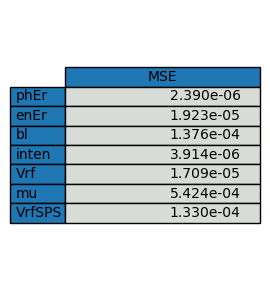

In [14]:
# Generate table and save
plt.figure(figsize=(2.8, 3))
plt.axis('off')
rowLabels = var_names
rowColours = ['tab:blue'] * len(rowLabels)
colColours = ['tab:blue']
cellColours = [['xkcd:light grey'] for i in range(len(rowLabels))]
cellText = [[f'{l:.3e}'] for l in test_mse]

plt.table(cellText=cellText, rowLabels=rowLabels, colLabels=['MSE'],
          loc='center', rowColours=rowColours, colColours=colColours,
          cellColours=cellColours)
plt.tight_layout()
plt.savefig(f'{plots_dir}/mse-table.jpg',
            dpi=400, bbox_inches='tight')


In [15]:

y_test_unnorm = unnormalize_params(
    y_test[:, 0], y_test[:, 1], y_test[:, 2],
    y_test[:, 3], y_test[:, 4], y_test[:, 5],
    y_test[:, 6], normalization=normalization)

y_pred_unnorm = unnormalize_params(
    test_pred[:, 0], test_pred[:, 1], test_pred[:, 2],
    test_pred[:, 3], test_pred[:, 4], test_pred[:, 5],
    test_pred[:, 6], normalization=normalization)

diffs = np.abs(np.array(y_pred_unnorm).T - np.array(y_test_unnorm).T)
print(diffs.shape)



(698, 7)


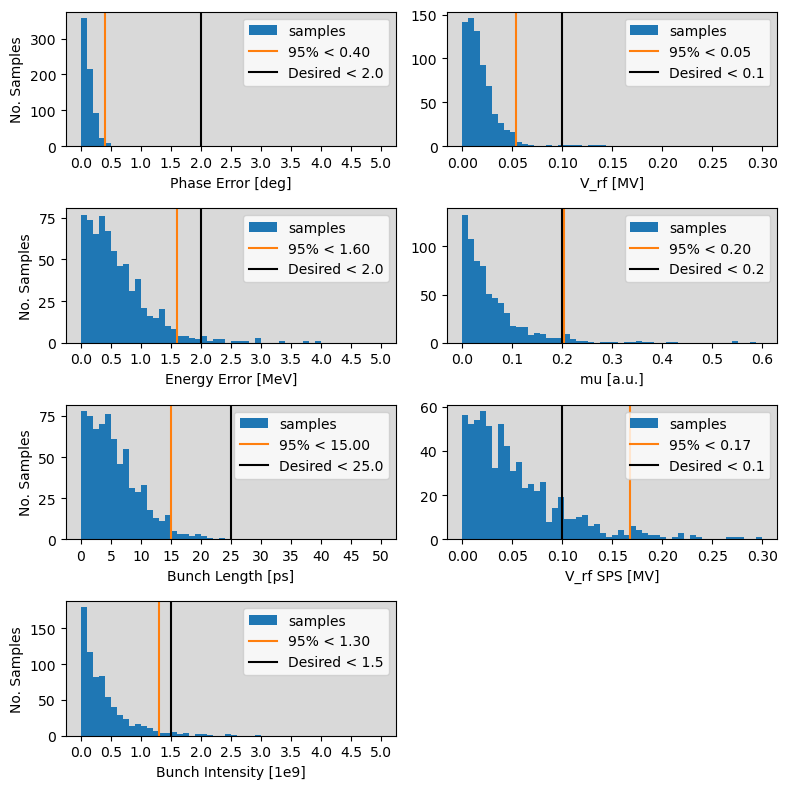

In [16]:
import bisect

# Encoder, graphical evaluation

evaluation_config = {
    0: {'xlabel': 'Phase Error [deg]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    1: {'xlabel': 'Energy Error [MeV]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    2: {'xlabel': 'Bunch Length [ps]',
        'range': (0, 50),
        'xticks': np.arange(0, 50.5, 5),
        'desired': 25,
        'multiplier': 1e12},
    3: {'xlabel': 'Bunch Intensity [1e9]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 1.5,
        'multiplier': 1e-9},
    4: {'xlabel': 'V_rf [MV]',
        'range': (0, 0.3),
        'xticks': np.arange(0, 0.31, 0.05),
        'desired': 0.1,
        'multiplier': 1},
    5: {'xlabel': 'mu [a.u.]',
        'range': (0, 0.6),
        'xticks': np.arange(0, 0.61, 0.1),
        'desired': 0.2,
        'multiplier': 1},
    6: {'xlabel': 'V_rf SPS [MV]',
        'range': (0, 0.3),
        'xticks': np.arange(0, 0.31, 0.05),
        'desired': 0.1,
        'multiplier': 1},
}

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=False,
                         sharey=False, figsize=(8, 8))
axes = np.ravel(axes, order='F')

for idx, ax in enumerate(axes):
    if idx == 7:
        break
    plt.sca(ax)
    config = evaluation_config[idx]
    hist, bins, _ = plt.hist(
        diffs[:, idx]*config['multiplier'], bins=50, range=config['range'], label='samples')
    cumsum = np.cumsum(hist) / diffs.shape[0]
    b = bisect.bisect(cumsum, 0.95)
    plt.axvline(x=bins[b+1], color='tab:orange',
                label=f'95% < {bins[b+1]:.2f}')
    plt.xticks(config['xticks'])
    plt.xlabel(config['xlabel'])
    if idx < 4:
        plt.ylabel('No. Samples')
    plt.axvline(x=config['desired'], color='black',
                label=f'Desired < {config["desired"]:.1f}')
    plt.legend(loc='upper right')
    plt.gca().set_facecolor('0.85')

# delete last
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(f'{plots_dir}/enc-abs-error.jpg',
            dpi=400, bbox_inches='tight')


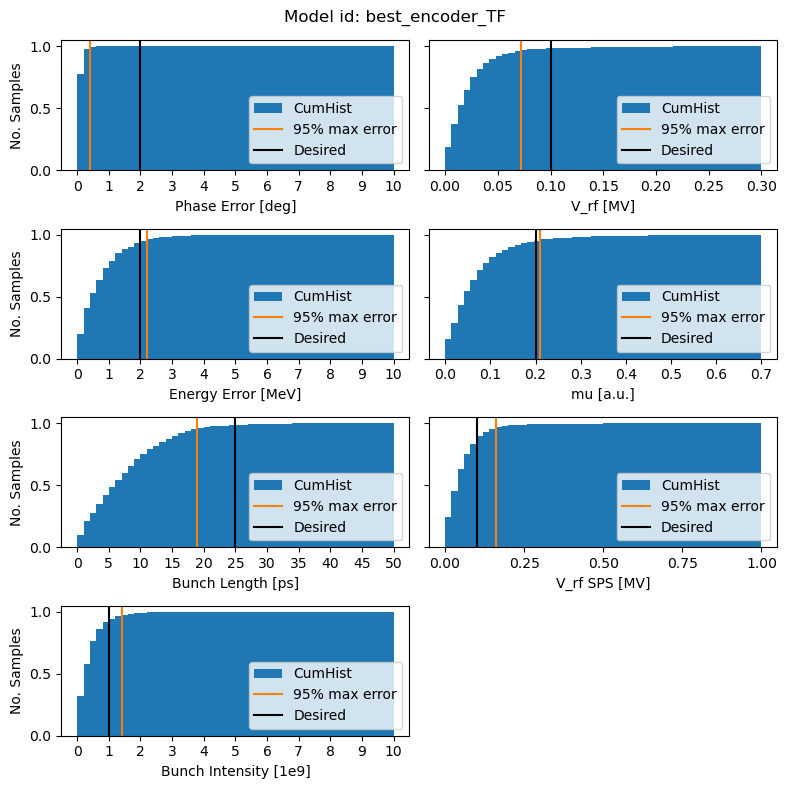

In [49]:
import bisect

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=False,
                         sharey=True, figsize=(8, 8))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0][0])
n, bins, patches = plt.hist(diffs[:, 0], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][0])
n, bins, patches = plt.hist(diffs[:, 1], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][0])
n, bins, patches = plt.hist(
    diffs[:, 2]*1e12, bins=50, range=(0, 50),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='black', label='Desired')
plt.legend(loc='lower right')


plt.sca(axes[3][0])
n, bins, patches = plt.hist(
    diffs[:, 3]*1e-9, bins=50, range=(0, 10),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5, 1))
plt.xlabel('Bunch Intensity [1e9]')
plt.ylabel('No. Samples')
plt.axvline(x=1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[0][1])
n, bins, patches = plt.hist(diffs[:, 4], bins=50, range=(0, 0.3),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][1])
n, bins, patches = plt.hist(diffs[:, 5], bins=50, range=(0, 0.7),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][1])
n, bins, patches = plt.hist(diffs[:, 6], bins=50, range=(0, 1),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

fig.delaxes(axes[3][1])

plt.tight_layout()
plt.savefig(f'plots/enc-cumulative-hist-{timestamp}.jpg', dpi=400)


In [ ]:
# Also generate MSE histogram
# print(valid_pred.shape)
# square_errors = ((y_test - test_pred) * (y_test - test_pred))

# fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
# sharey=True, figsize=(8, 16))
# for i, name in enumerate(var_names):
#     hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
#     hist = hist / len(square_errors[:, i])
#     print(name, hist)
#     ax = axes[i]
#     plt.sca(ax)
#     plt.bar(np.arange(len(hist)), hist, width=0.8)
#     plt.title(name)
#     edges = [f'{e:.4f}' for e in edges]
#     plt.xticks(np.arange(len(hist)), edges[1:])
#     plt.xlabel('Error')
#     plt.ylabel('Density')
#     plt.tight_layout()
